# This tests the similarity metric for Figure 7.1

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict


In [4]:
binary_data = pickle.load(open("binary_oxide_data_form_ene_self_calc_fingerprints.p", "rb"))
unary_data = pickle.load(open("unary_oxide_data_self_calc.p", "rb"))

similarity_metric = 0.5
coarse_predictions = []
y = []
matched_binaries = []
element2ox_change = defaultdict(list)
element2stabilization = defaultdict(list)

maes = []
similarity_metrics = np.linspace(0.1, 1.5, 15)
for similarity_metric in similarity_metrics:
    coarse_predictions = []
    y = []
    matched_binaries = []

    for combination in binary_data:
        element1, element2 = combination.split("_")
        if element1 not in unary_data.keys() or element2 not in unary_data.keys():
            continue
        for binary_index, binary_fingerprint in enumerate(binary_data[combination]['fingerprints']):
            binary_structure = binary_data[combination]['structures'][binary_index]
            amount_ele1 = binary_structure.composition.as_dict()[element1]
            amount_ele2 = binary_structure.composition.as_dict()[element2]
            amount_o = binary_structure.composition.as_dict()["O"]
            o_proportion = amount_o/(amount_o+amount_ele2+amount_ele1)
            if o_proportion<(2/3):
                # ONLY MO2 or higher stoichiometric O ratio
                continue
            for unary_element1_index, unary1_fingerprint in enumerate(unary_data[element1]['fingerprints']):
                for unary_element2_index, unary2_fingerprint in enumerate(unary_data[element2]['fingerprints']):
                    # only try to make a prediction if each compared oxide is 'similar' as defined by the similarity metric
                    difference_1 = np.linalg.norm(binary_fingerprint - unary1_fingerprint)
                    difference_2 = np.linalg.norm(binary_fingerprint - unary2_fingerprint)
                    difference_3 = np.linalg.norm(unary1_fingerprint - unary2_fingerprint)
                    if difference_1<similarity_metric and difference_2<similarity_metric and difference_3<similarity_metric:                    
                        ratio = amount_ele1/(amount_ele1+amount_ele2)

                        # grabs the energy at V=1.6
                        stability_ele1 = unary_data[element1]['energies'][unary_element1_index][6]
                        stability_ele2 = unary_data[element2]['energies'][unary_element2_index][6]
                        
                        stability_ele1 = unary_data[element1]['formation_energies'][unary_element1_index]
                        stability_ele2 = unary_data[element2]['formation_energies'][unary_element2_index]
                        
                        pred = ratio*stability_ele1 + (1-ratio)*stability_ele2
                        true_stability = binary_data[combination]['formation_energies'][binary_index]
                        
                        y.append(true_stability) 
                        coarse_predictions.append(pred)

    mae = np.mean(abs(np.asarray(y)-np.asarray(coarse_predictions)))
    maes.append(mae)



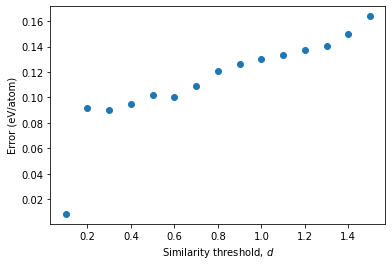

In [5]:
plt.plot(similarity_metrics, maes, 'o')
plt.xlabel("Similarity threshold, $d$")
plt.ylabel("Error (eV/atom)")
